# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [5]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

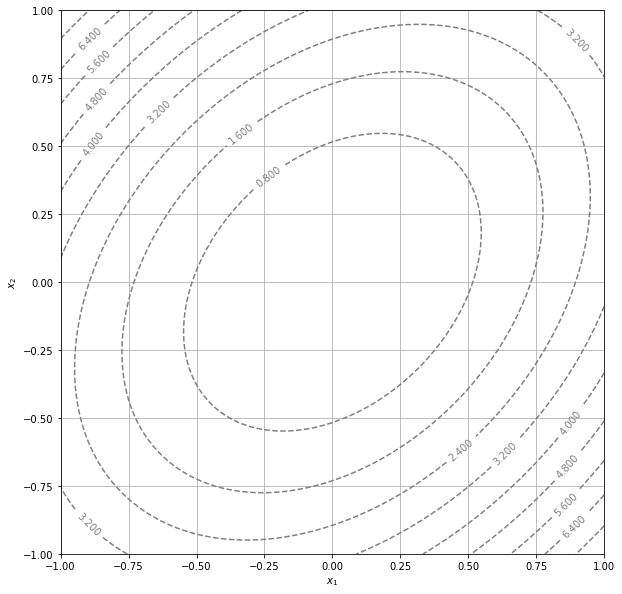

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

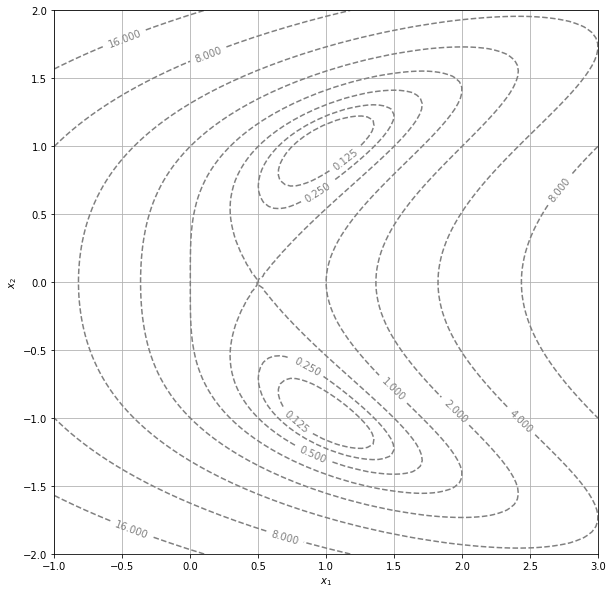

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

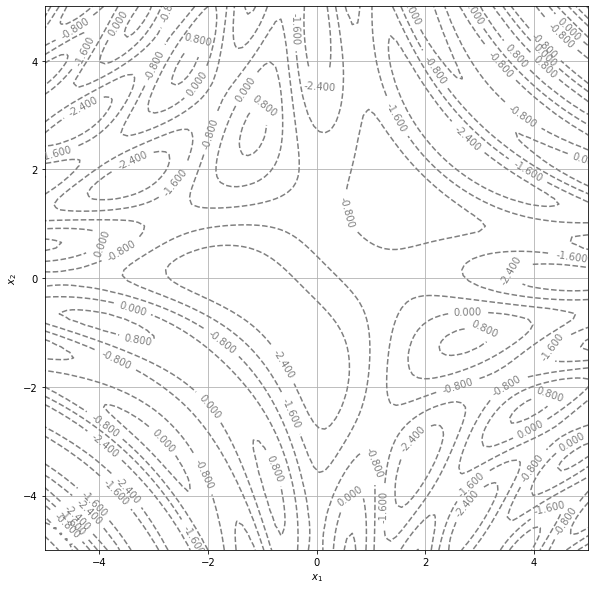

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$



### Réponse 

Notons X l'ensemble de niveau $c$ de $f$. D'une part, comme $f$ et continue, et puisque $X=f^{-1}\{c\}$, $X$ est fermé.
D'autre part, comme $\lim_{\|x\| \to +\infty} \|f(x)\|=+\infty$, X est nécessairement borné. En effet, dans le cas contraire, on trouve $M>0$ tel que $\forall x$ vérifiant $\|x\|>M$ on ait $\|f(x)\|>c+1$ et comme X est supposé non borné, on trouve $x\in X $ qui vérifie $ \|x\|>M$, d'où la contradiction par définition de X. Puisqu'on est en dimension finie, X est compact en tant que fermé et borné.



#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

### Réponse 

On pose $\begin{equation}\theta = \frac{\nabla f_{x_{0}}}{\|\nabla f_{x_{0}}\|} \end{equation}$

Et $v=R\theta$ 

Avec $R=\begin{pmatrix}
   0 & 1 \\
   -1 & 0 
\end{pmatrix}$ la rotation de $\frac{\pi}{2}$


Alors $(\theta,v)$ est une base orthonormée. 
Et pour $x\in\mathbb{R}^{2}$:

$$<x-x_{0},v>= \frac{\partial_{1}f(x_{0})}{\|\nabla f_{x_{0}}\|}(x_{1}-x_{01})-\frac{\partial_{2}f(x_{0})}{\|\nabla f_{x_{0}}\|}(x_{2}-x_{02})=p(x)$$

Donc $p(x)$ est la coordonée de $x-x_{0}$ selon $v$ dans la base orthonormée $(\theta,v)$

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

### Réponse   
 
 On pose $\begin{equation}\theta = \frac{\nabla f_{x_{0}}}{\|\nabla f_{x_{0}}\|} \end{equation}$
 
 Soit $v \in\mathbb{R}^{2}$ tel que $(v,\theta$) soit une base orthonormée.
 
 Pour $x \in\mathbb{R}^{2}$ en vertu de Q2), on peut écrire $$x-x_{0} = p(x)v + \alpha(x)\theta$$ (avec $\alpha = \theta^{*}$)  
 
 On a de plus $$f(x)=c\Leftrightarrow f(p(x)v + \alpha(x)\theta +x_{0}) - c=0$$
 
 Cette expression est continûment différentiable par rapport au couple $(p(x),\alpha(x))$ et pour $h\in\mathbb{R}$,
 
 $\partial_{\alpha}(f(p(x)v+\alpha (x)\theta +x_{0})-c).h$ 
 
 = $df((p(x)v+\alpha (x)\theta +x_{0}).\theta h$
 
 =$ <h\frac{\nabla f_{x_{0}}}{\|\nabla f_{x_{0}}\|},\nabla f_{x}>$
 
 En particulier, $\partial_{\alpha}f(x_{0})=(h\to \|\nabla f_{x_{0}}\|h)$  est inversible car $\|\nabla f_{x_{0}}\|\ne 0$
 
 D'après le théorème des fonctions implicites, il existe $\epsilon>0$ et $\psi : ]-\epsilon,+\epsilon[\to\mathbb{R}$ continûment différentiable tel que:
 
 $$ \forall x \in B(x_{0},\epsilon),  f(x)=c\Leftrightarrow \alpha(x)=\psi(p(x))$$
 
 On a le résultat cherché en posant :

$\begin{array}{ccccc}
\gamma & : & ]-\epsilon,+\epsilon[\to\mathbb{R}^{2}\\
 & &t& \mapsto& tv +\psi(t)\theta \\
\end{array}$
 
qui est continûment différentiable. 


#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

### Réponse 

Pour $t\in ]-\epsilon,+\epsilon[$ on a:

$\gamma'(t) = v + \psi'(t)\theta \ne 0$ car $(v,\theta)$ est libre

De plus, on a:
$$\forall t \in ]-\epsilon,+\epsilon[,f(\gamma(t))=c$$

D'où en dérivant

$$\forall t \in ]-\epsilon,+\epsilon[, df(\gamma(t)).\gamma'(t)=0$$

Soit finalement  $<\gamma'(t),\nabla f(\gamma(t))>$ = $0$

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

### Réponse 

Non, il suffit d'avoir une précision assez petite pour que l'approximation et la réponse réelle se confondent sur un pixel du graphique matplotlib.

In [63]:
N = 1000
eps = 0.001

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [153]:
def Newton(F, x0, y0, eps=eps, N=N):
    x=x0
    y=y0
    for i in range(N):
        M=J(F)(x0, y0)
        (x, y) = (x0, y0) - np.dot(np.linalg.inv(M), F(x0, y0))
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")


#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [154]:
def f1_newton(x, y):
    return np.array((f1(x, y)-0.8,  x-y))

def f1_bis (x,y) :
    return f1(x, y) - 0.8

print(Newton(f1_newton, 0.8,0.8))

def f3_newton(x,y):
     return np.array((f3(x, y)-0.0,  x-y))

print(Newton(f3_newton, 0.8,0.8))    

(0.4472135970019964, 0.4472135970019964)
(-1.6276538777195568, -1.6276538777195568)


### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

### Réponse

On modifie la fonction en rajoutant une deuxième composante, qui quand elle s'annule impose à $(x,y)$ d'être à une distance $\delta$ de $(x_{0},y_{0})$. On effectue à partir de cette fonction une méthode de Newton obtenue à partir du point translaté de $(x_{0},y_{0})$ par la normale au gradient de f en $(x_{0},y_{0})$. 

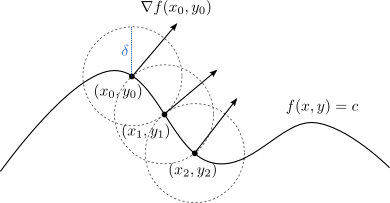

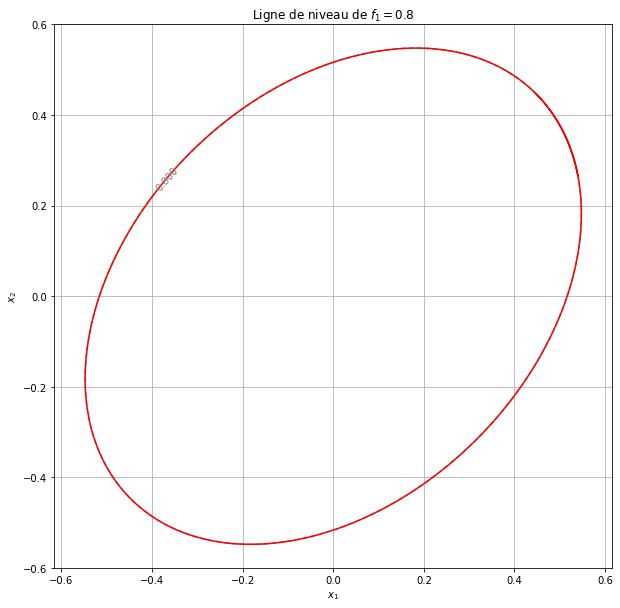

In [155]:
def level_curve(f, x0, y0, delta=0.001, N=1000, eps=eps):
   c = f(x0, y0)
   tab = np.zeros((2,N))
   tab[0][0] = x0
   tab[1][0] = y0
   g = autograd.grad
   for i in range(1,N) :
      a, b = x0, y0
      def F(x, y) :
         return np.array([f(x,y)-c, np.sqrt((x-a)**2+(y-b)**2) - delta]) # On veut annuler f(x,y) - c et imposer à (x,y) de rester sur le cercle de rayon delta
      normal_gradient = np.dot(1/np.sqrt(g(f,0)(x0,y0)**2 + g(f,1)(x0,y0)**2),np.array([g(f,1)(x0,y0), -g(f,0)(x0,y0)])) 
      (x0, y0) = (x0, y0) +  np.dot(delta, normal_gradient)
      x0, y0 = Newton(F, x0, y0) # On effectue une méthode de Newton au translaté de (x0, y0) par la normale au gradient de f en (x0, y0)
      tab[0][i] = x0
      tab[1][i] = y0
   return tab


display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels= [0.8] 
)

x0, y0 = Newton(f1_newton,0.8,0.8)

coord = level_curve(f1, x0, y0, 0.0025,1450)
plt.plot(coord[0], coord[1], c='r')
plt.axis("equal")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Ligne de niveau de $f_1=0.8$")
plt.grid(True)

plt.show()



### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

#### Réponse 

On doit vérifier l'intersection avec tous les segments déjà produits lorsque le courbe de niveau est "auto-intersectante". En supposant qu'une telle courbe correspond à une fonction continûment différentiable, on montre que le gradient s'annule au point d'intersection et il n'est donc plus possible de faire une méthode de Newton en ce point. En effet on a vu à la question 4 que si le gradient n'est pas nul alors il est orthogonal à la courbe de niveau. Il aurait ici deux directions différentes et serait donc nul ce qui est absurde.

Les fonctions auto-intersectantes sont donc très rares pour notre usage puisque nous travaillons d'une part avec des fonctions au moins continûment différentiables et d'autre part en des points où le gradient ne s'annule pas sans quoi la méthode de Newton échoue.

In [147]:
# Pour savoir si deux segments s'intersectent on regarde si la solution potentielle (qu'on calcule comme intersection des deux 
def intersection(xa,xb,x1,x2,ya,yb,y1,y2):
  
    M=np.array([[xb-xa,x1-x2],[yb-ya,y1-y2]])
    if np.linalg.det(M)==0:
        return False
    else:
        M_inv=np.linalg.inv(M)
        Z=np.array([x1-xa,y1-ya])
        t1,t2=np.dot(M_inv,Z)
        if 0<t1<1 and 0<t2<1:
            return True
        else:
            return False
        



def level_curve2(f, x0, y0, delta=0.001, N=1000, eps=eps):
   c = f(x0, y0)
   tab = np.zeros((2,N))
   tab[0][0] = x0
   tab[1][0] = y0
   g = autograd.grad

   for i in range(1,N) :
       a, b = x0, y0
       def F(x, y) :
         return np.array([f(x,y)-c, np.sqrt((x-a)**2+(y-b)**2) - delta])
       normal_gradient = np.dot(1/np.sqrt(g(f,0)(x0,y0)**2 + g(f,1)(x0,y0)**2),np.array([g(f,1)(x0,y0), -g(f,0)(x0,y0)])) 
       (x0, y0) = (x0, y0) +  np.dot(delta, normal_gradient)
       x0, y0 = Newton(F, x0, y0) # On effectue une méthode de Newton au translaté de (x0, y0) par la normale au gradient de f en (x0, y0)
       tab[0][i] = x0
       tab[1][i] = y0

       if i>= 2 :
          x1 = tab[0][0]
          y1 = tab[1][0]
          x2 = tab[0][1]
          y2 = tab[1][1]
          xa = tab[0][i-1]
          ya = tab[1][i-1]
          xb = x0
          yb = y0
          if intersection(xa,xb,x1,x2,ya,yb,y1,y2) :
              return tab[::,0:i]


   return tab

False


#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

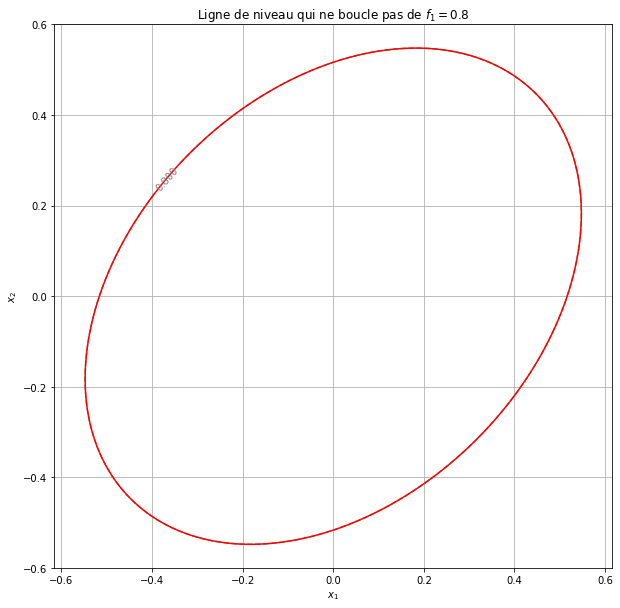

In [76]:
x0,y0 = Newton(f1_newton,0.8,0.8)
X = level_curve2(f1,x0,y0,0.0025,1400)

display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels= [0.8] 
)
plt.plot(X[0],X[1],c='r')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Ligne de niveau qui ne boucle pas de $f_1=0.8$")
plt.grid(True)
plt.axis("equal")
plt.show()

## Post-traitement

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

### Réponse 

Notons $P_{1}=(x_{1},y_{1})$  $P_{2}=(x_{2},y_{2})$
      
$u_{1}=(u_{11},u_{12})$     $u_{2}=(u_{21},u_{22})$
       
 et $ \lambda$, $\mu$ des réels positifs
 
 Nous disposons des équations suivantes:
 
 $\gamma(0)=(a,d)=(x_{1},y_{1})$
 
 $\gamma(1)=(a+b+c,d+e+f)=(x_{2},y_{2})$
 
 $\gamma'(0)=(b,e)=\lambda(u_{11},u_{12})$
 
 $\gamma'(1)=(b+2c,e+2f)=\mu(u_{21},u_{22})$
 
 De manière évidente:
 
 $a=x_{1}$
 
 $d=y_{1}$
 
 Puis on détermine $\lambda$, après calculs:
 
 
 $\lambda=\frac{2((x_{2}-x_{1})u_{22}-(y_{2}-y_{1})u_{21}))}{u_{11}u_{22}-u_{12}u_{21}}$
 
 Puis
 
 $\mu = \frac{-\lambda u_{12}+2(y_{2}-y_{1})}{u_{22}}$
 
 $b=\lambda u_{11}$
 
 
 $c=x_{2}-b-a$
 
 $e=\lambda u_{12}$
 
 $f=y_{2}-d-e$
 

 #### Conditions d'existence de la solution:
 
 D'une part, le dénominateur de $\lambda$ ne s'annulant pas, on remarque que $u_{1}$ et $u_{2}$ ne peuvent être colinéaires, le dénominateur étant la composante du produit vectoriel de ces deux vecteurs selon $z$ et d'autre part $\lambda$ et $\mu$ doivent être strictement positifs



#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [156]:
def gamma(t,P1,P2,u1,u2):
    x1,y1 = P1[0],P1[1]
    x2,y2 = P2[0],P2[1]
    u11,u12 = u1[0],u1[1]
    u21,u22 = u2[0],u2[1]
    vect = np.array([x1+t*(x2-x1),y1+t*(y2-y1)])
    if u11*u22==u12*u21:
        return vect
    lambd = (2*(x2-x1)*u22 - 2*(y2-y1)*u21)/(u11*u22 - u12*u21)
    mu = (2*(y2-y1)-lambd*u12)/u22
    
    if lambd<=0 or mu<=0:
        return vect
    
    else:
        a = x1
        b = lambd*u11
        c = x2 - b - a
        d = y1
        e = lambd*u12
        f = y2 - e - d
        x = a + b*t + c*t**2
        y = d + e*t + f*t**2
        
    return np.array([x,y])
            
            
            

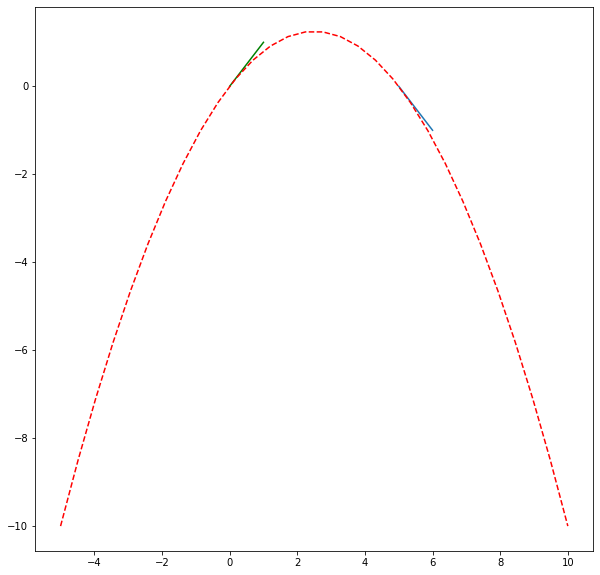

In [158]:
def Gamma (L,P1,P2,u1,u2) :
    return np.array([gamma(t,P1,P2,u1,u2)[0] for t in L]),np.array([gamma(t,P1,P2,u1,u2)[1] for t in L])


L = np.linspace(-3,3,40)


plt.plot([0,1],[0,1],'g')#affichage de U1
plt.plot([5,6],[0,-1])#affichage de U2

L = np.linspace(-1,2,30)
T = Gamma (L,(0,0),(5,0),(1,1),(1,-1))

plt.plot(T[0],T[1],'--r')



### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [159]:
def level_curve3(f, x0, y0, delta=0.001, N=1000, eps=eps, oversampling=1):
    c = f(x0,y0)
    g = autograd.grad
    tab = [[x0, y0]]
    c = f(x0, y0)
    def f_c(x1, x2):
        return f(x1, x2) - c
    for i in range(1, N):
        vect = np.dot(1/np.sqrt(g(f_c,0)(x0,y0)**2 + g(f_c,1)(x0,y0)**2),(g(f_c,1)(x0,y0), -g(f_c,0)(x0,y0)))
        a,b = x0,y0
        def F(x,y):
            return np.array([
                f(x,y)-c,
                (x - a)**2 + (y - b)**2 - delta**2
            ])
            
        (x0, y0) = (x0, y0) + np.dot(delta,vect)        
        x0, y0 = Newton(F, x0, y0)
        tab.append([x0, y0])
    if oversampling==1:
        coord = np.array(tab)
        coordonnées = coord.T
        return coordonnées
    else:
        tab = tab[0] + (Gamma(np.linspace(0,1,oversampling+1),tuple(tab[0]), tuple(tab[1]), (tab[1][0]-tab[0][0],tab[1][1]-tab[0][1]), (tab[1][0]-tab[0][0],tab[1][1]-tab[0][1])).T).tolist() + tab[1::]
        for i in range(1,N):
            tab = tab[0:(oversampling-1)*i+1] + (Gamma(np.linspace(0,1,(oversampling-1)+1),tuple(tab[i+oversampling*i]), tuple(tab[i+(oversampling-1)*i+1]), (tab[i+(oversampling-1)*i][0]-tab[i+(oversampling-1)*i-1][0],tab[i+(oversampling-1)*i][1]-tab[i+(oversampling-1)*i-1][1]), (tab[i+(oversampling-1)*i+2][0]-tab[i+(oversampling-1)*i+1][0],tab[(oversampling-1)*i+2][1]-tab[(oversampling-1)*i+1][1])).T).tolist() + tab[(oversampling-1)*i+1:]
            # On insère les nouveaux points au bon endroit dans le tableau
        coord = np.array(tab)
        coordonnées = coord.T
        return coordonnées

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

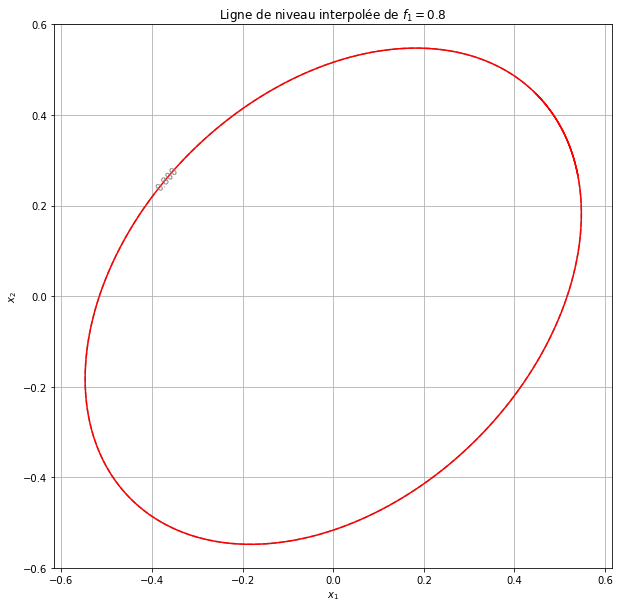

In [161]:
x0,y0 = Newton(f1_newton,0.8,0.8)
X = level_curve3(f1,x0,y0,0.0025,1450,10)
display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels= [0.8] 
)
plt.plot(X[0],X[1],c='r')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Ligne de niveau interpolée de $f_1=0.8$")
plt.grid(True)
plt.axis("equal")
plt.show()